In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

experiments = pd.read_parquet("results_iterations.parquet")
experiments["error"] = np.abs(experiments["estimate"])
experiments["seed"] = 324*[i for i in range(10000)]

range_ns = np.unique(experiments["n"])
range_deltas = -np.sort(-np.unique(experiments["delta"]))
range_distributions = np.unique(experiments["distribution"])

# organize results
df_grouped = [ experiments[ experiments["delta"] == delta ].groupby(["n", "delta", "method", "distribution"])["error"].quantile(1-delta).reset_index() for delta in range_deltas ]
df_grouped = pd.concat(df_grouped)

df_grouped_pivot = df_grouped.pivot(index=['n', 'delta', 'distribution'], columns='method', values='error').reset_index()
df_grouped_pivot["tm"] = (df_grouped_pivot["tm win"] -  df_grouped_pivot["tm"])/df_grouped_pivot["tm"]
df_grouped_pivot["mean"] = (df_grouped_pivot["mean win"] -  df_grouped_pivot["mean"])/df_grouped_pivot["mean"]

del df_grouped_pivot["mean win"]
del df_grouped_pivot["mean 2x win"]
del df_grouped_pivot["tm win"]
del df_grouped_pivot["tm 2x win"]

df_grouped = df_grouped_pivot.melt(id_vars=['n', 'delta', 'distribution'], 
                                    var_name='baseline', 
                                    value_name='change')

df_grouped

,n,delta,distribution,baseline,change
0,50,0.001,Gaussian,mean,0.017163
1,50,0.001,St df=2.01,mean,-0.603785
2,50,0.010,Gaussian,mean,0.014389
3,50,0.010,St df=2.01,mean,-0.564530
4,50,0.100,Gaussian,mean,0.014604
...,...,...,...,...,...
103,450,0.001,St df=2.01,tm,0.066024
104,450,0.010,Gaussian,tm,-0.000104
105,450,0.010,St df=2.01,tm,0.006207
106,450,0.100,Gaussian,tm,0.001418


Gaussian
St df=2.01


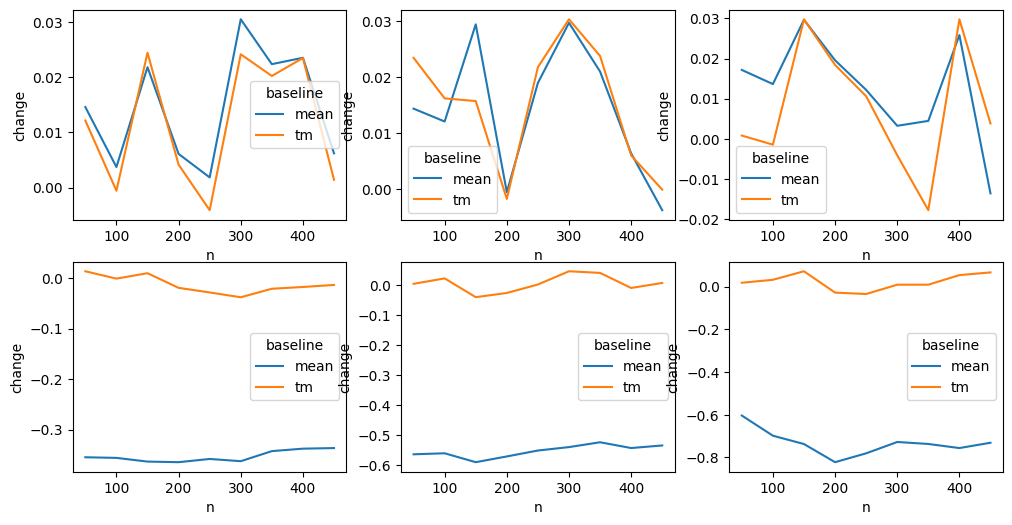

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for j, dist in enumerate(range_distributions):   
    print(dist) 
    for i, delta in enumerate(range_deltas):
        ax = axes[j][i]
        subset = df_grouped[(df_grouped['distribution'] == dist) & (df_grouped['delta'] == delta)]

        sns.lineplot(subset, x="n", y="change", hue="baseline", ax=ax)

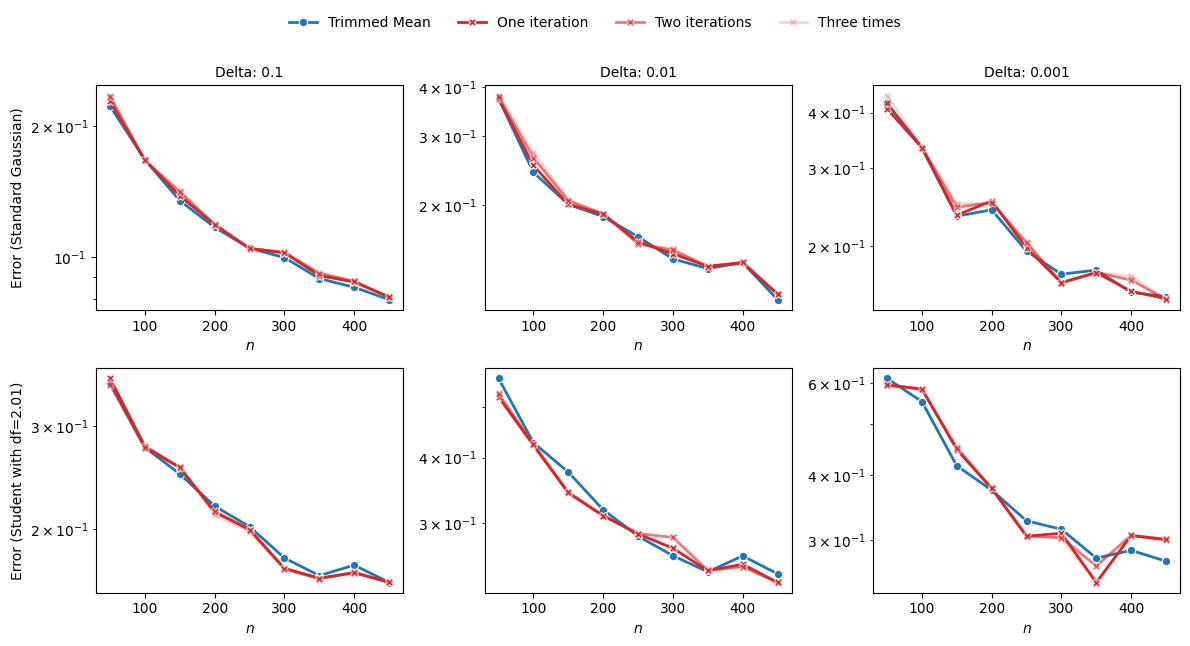

In [13]:
method_styles = {
    'tm': {'linestyle': '-', 'marker': 'o', 'color': 'C0', 'alpha': 1},
    'win': {'linestyle': '-', 'marker': 'X', 'color': 'C3', 'alpha': 1},
    '2x win': {'linestyle': '-', 'marker': 'X', 'color': 'C3', 'alpha': .6},
    '3x win': {'linestyle': '-', 'marker': 'X', 'color': 'C3', 'alpha': .2}
}
method_order = [key for key in method_styles]
labels = ["Trimmed Mean", "One iteration", "Two iterations", "Three times"]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for j, dist in enumerate(range_distributions):    
    for i, delta in enumerate(range_deltas):
        ax = axes[j][i]
        for method in method_order:
            subset = df_grouped[(df_grouped['distribution'] == dist) & (df_grouped['delta'] == delta) & (df_grouped['method'] == method)]
            sns.lineplot(data=subset, x='n', y='error', ax=ax, lw=2, label=method, color=method_styles[method]['color'], alpha=method_styles[method]['alpha'],
                            linestyle=method_styles[method]['linestyle'], marker=method_styles[method]['marker'])
        if j == 0:
            ax.set_title(f'Delta: {delta}', fontsize=10)
        ax.set_xlabel(r'$n$')
        ax.set_yscale("log")
        if i == 0:
            if j == 0:
                ax.set_ylabel('Error (Standard Gaussian)')
            else:
                ax.set_ylabel('Error (Student with df=2.01)')
        else:
            ax.set_ylabel('')
        
handles, _ = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor = (0, .08, 1, 1), frameon=False)

for ax in axes.flatten():
    ax.get_legend().remove()

plt.tight_layout()
plt.savefig("iterations.pdf", bbox_inches = 'tight', pad_inches = 0)